# KE5105 - Building Electrical Consumption Forecasting

# Modelling 7 - Preliminary model

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [5]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [10]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

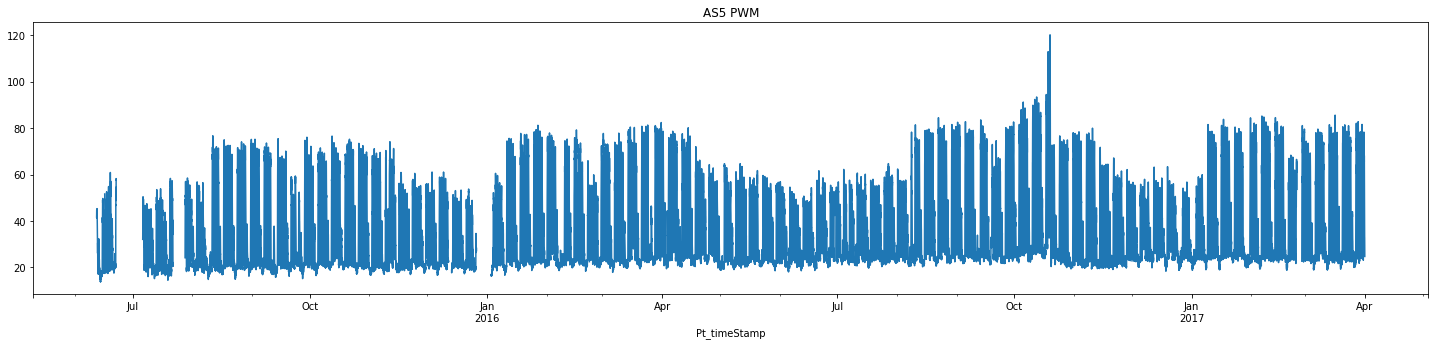

In [11]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

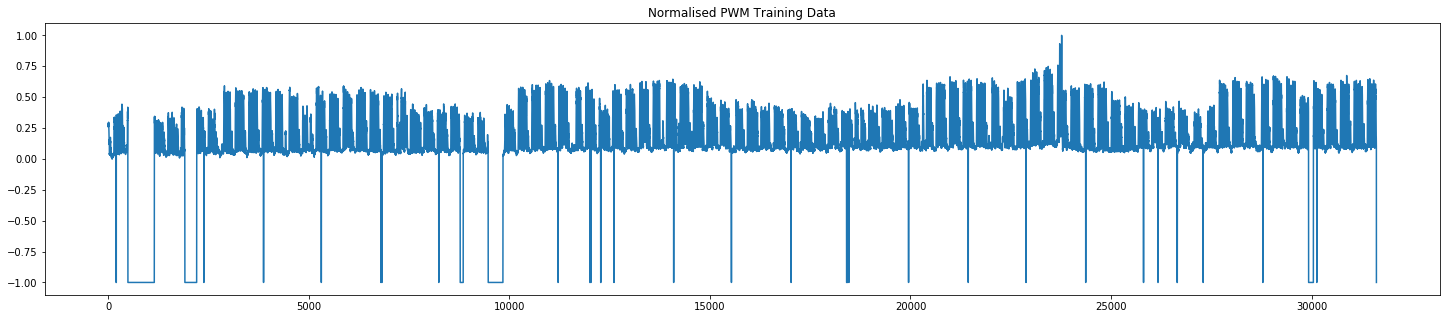

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

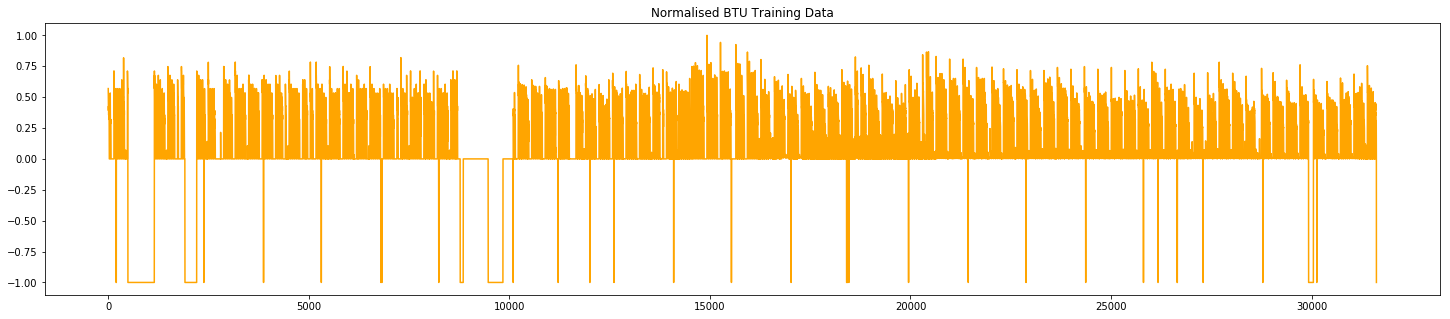

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [17]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [18]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and No Recurrent Dropout

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100.h5'))
model.summary()

In [43]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
Epoch 1/50
 - 86s - loss: 0.0171 - mean_absolute_percentage_error: 12.0224 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.9647
Epoch 2/50
 - 85s - loss: 0.0168 - mean_absolute_percentage_error: 11.6243 - val_loss: 0.0344 - val_mean_absolute_percentage_error: 15.3454
Epoch 3/50
 - 87s - loss: 0.0167 - mean_absolute_percentage_error: 11.6560 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 13.5094
Epoch 4/50
 - 86s - loss: 0.0166 - mean_absolute_percentage_error: 11.5926 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 11.5723
Epoch 5/50
 - 85s - loss: 0.0168 - mean_absolute_percentage_error: 11.5655 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.3368
Epoch 6/50
 - 85s - loss: 0.0164 - mean_absolute_percentage_error: 11.4245 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 15.7287
Epoch 7/50
 - 86s - loss: 0.0166 - mean_absolute_percentage_error: 11.5572 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.9357
Epoch 8/50


In [44]:
# histories = [] # for first training session
histories.append(history.history)

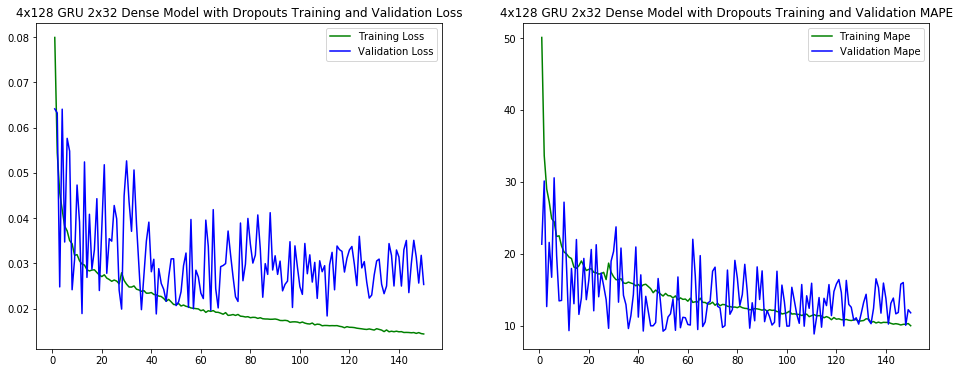

In [45]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [46]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.534367
Validation MAE = 2.505476


In [47]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [48]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

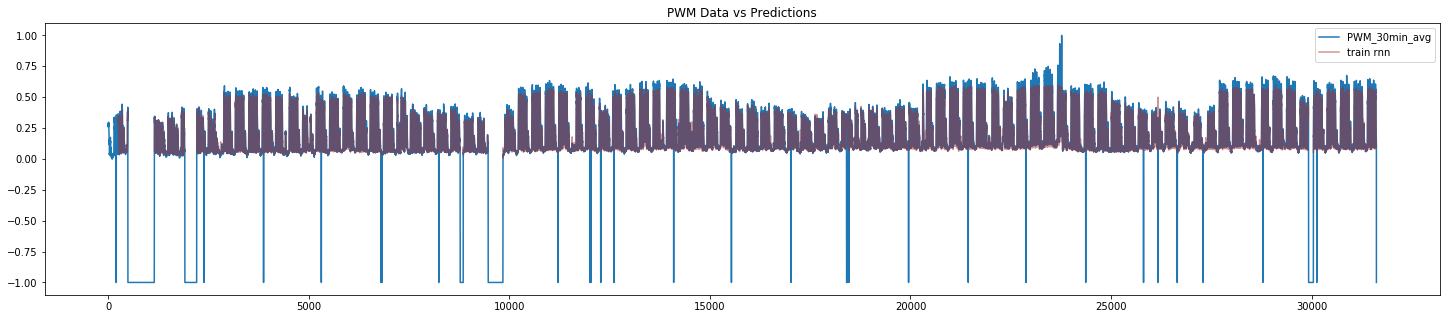

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

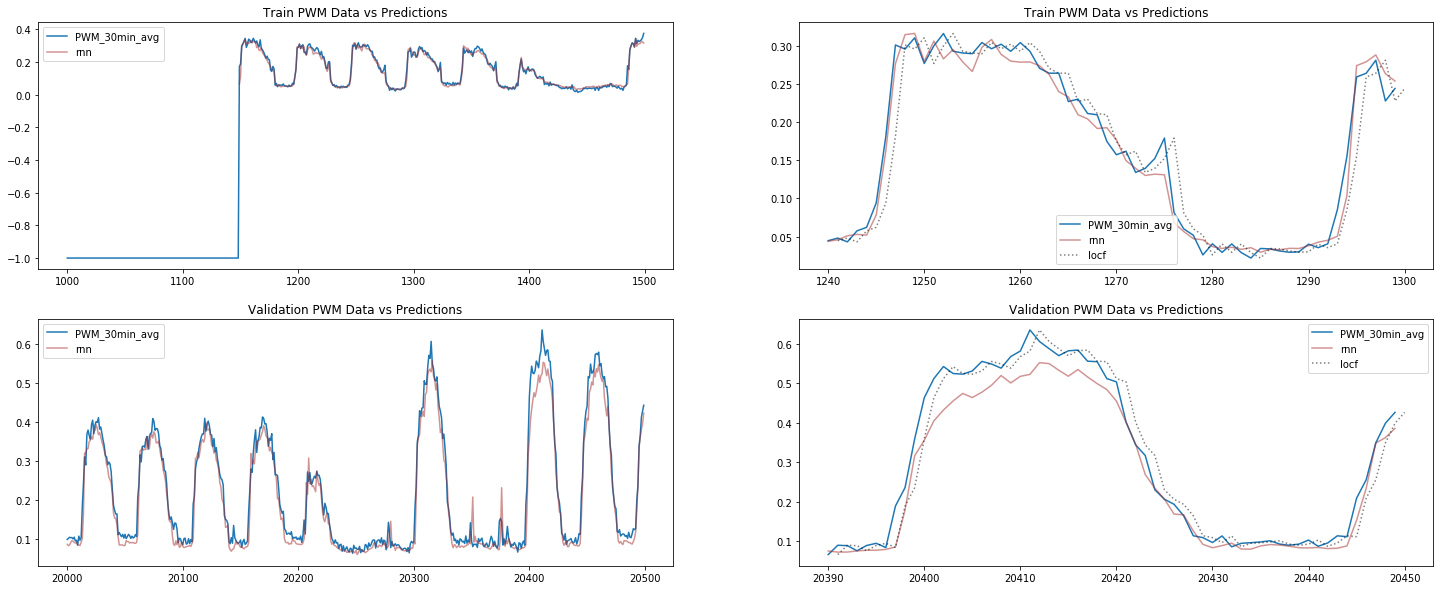

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base-4x128gru-2x32dense-dropout0100.h5')

In [52]:
with open('base-4x128gru-2x32dense-dropout0100-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [43]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 91s - loss: 0.0163 - mean_absolute_percentage_error: 10.9840 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 11.3677
Epoch 2/50
 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1946 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 13.9685
Epoch 3/50
 - 91s - loss: 0.0169 - mean_absolute_percentage_error: 11.3835 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 11.0788
Epoch 4/50
 - 91s - loss: 0.0169 - mean_absolute_percentage_error: 11.3207 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 12.0514
Epoch 5/50
 - 92s - loss: 0.0168 - mean_absolute_percentage_error: 11.3684 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 11.6396
Epoch 6/50
 - 91s - loss: 0.0170 - mean_absolute_percentage_error: 11.2922 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 11.5798
Epoch 7/50
 - 91s - loss: 0.0167 - mean_absolute_percentage_error: 11.3904 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 16.8148
Epoch 8/50
 - 92s - 

In [44]:
# histories = []  # for first training session
histories.append(history.history)

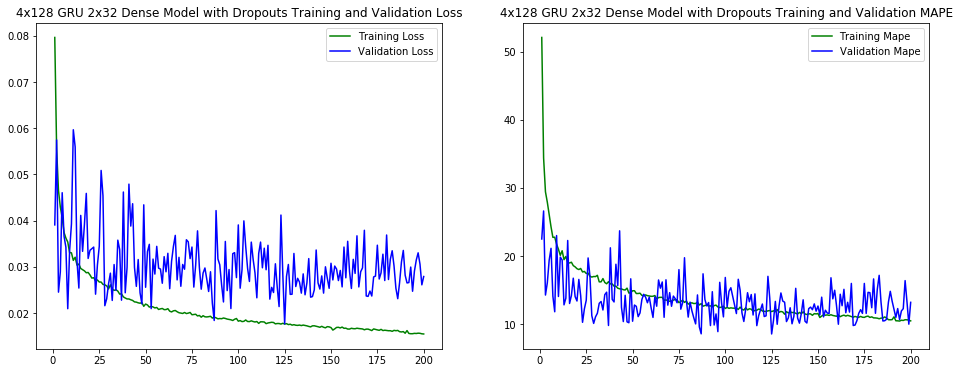

In [45]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [46]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.644406
Validation MAE = 2.628233


In [47]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [48]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

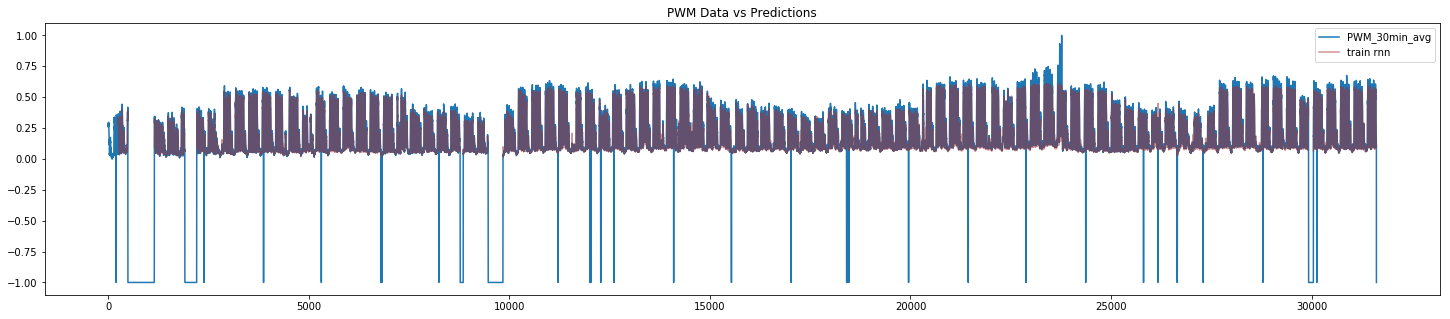

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

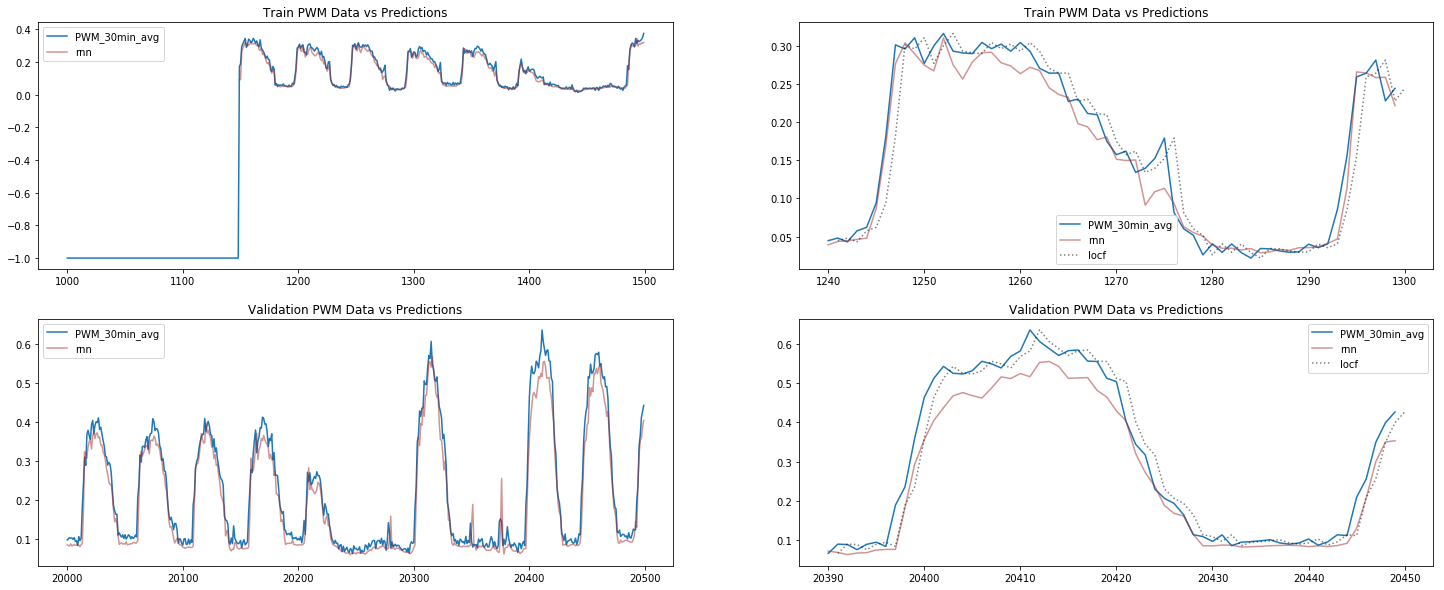

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base-4x128gru-2x32dense-dropout0102-epch200.h5')

In [52]:
with open('base-4x128gru-2x32dense-dropout0102-epch200-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and Recurrent Dropout (0.4)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0104-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0104-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [54]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.0377 - val_loss: 0.0342 - val_mean_absolute_percentage_error: 17.3515
Epoch 2/50
 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3671 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 14.3414
Epoch 3/50
 - 94s - loss: 0.0167 - mean_absolute_percentage_error: 11.3488 - val_loss: 0.0324 - val_mean_absolute_percentage_error: 13.9184
Epoch 4/50
 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3482 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 12.3876
Epoch 5/50
 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3245 - val_loss: 0.0345 - val_mean_absolute_percentage_error: 15.3350
Epoch 6/50
 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.1723 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 13.8063
Epoch 7/50
 - 94s - loss: 0.0160 - mean_absolute_percentage_error: 10.8153 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 14.1514
Epoch 8/50
 - 95s - 

In [55]:
# histories = []  ## if first training session
histories.append(history.history)

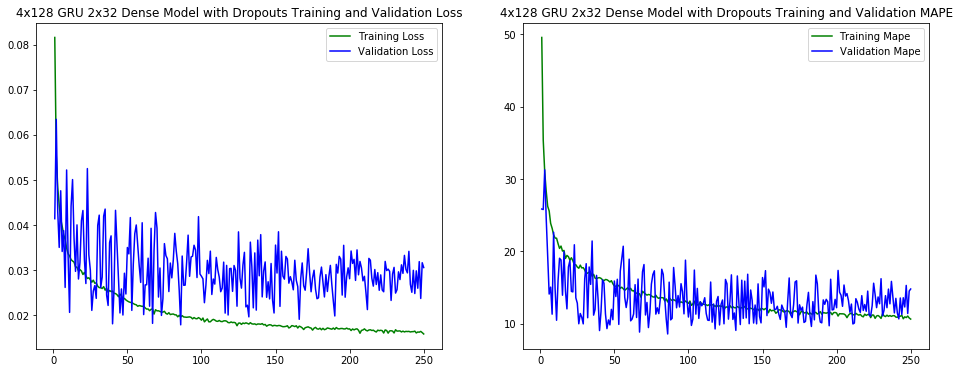

In [56]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [60]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.681443
Validation MAE = 2.520015


In [61]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [62]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

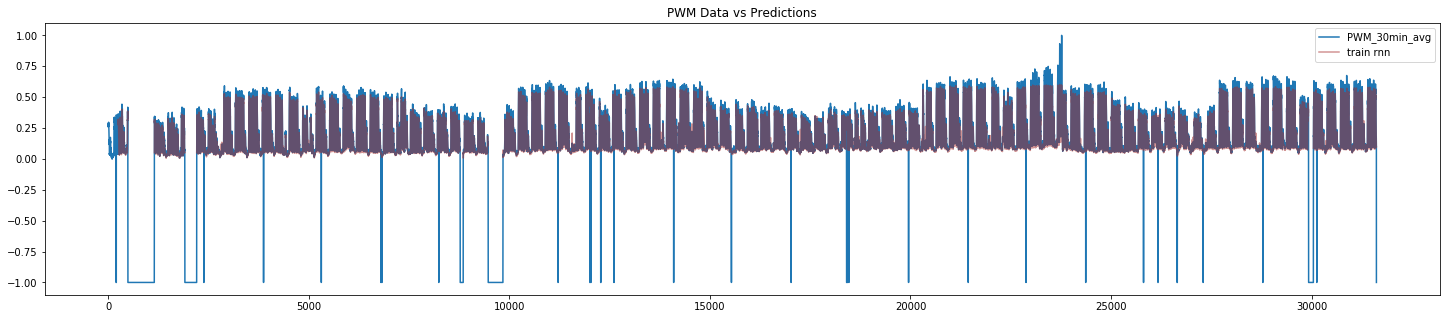

In [63]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

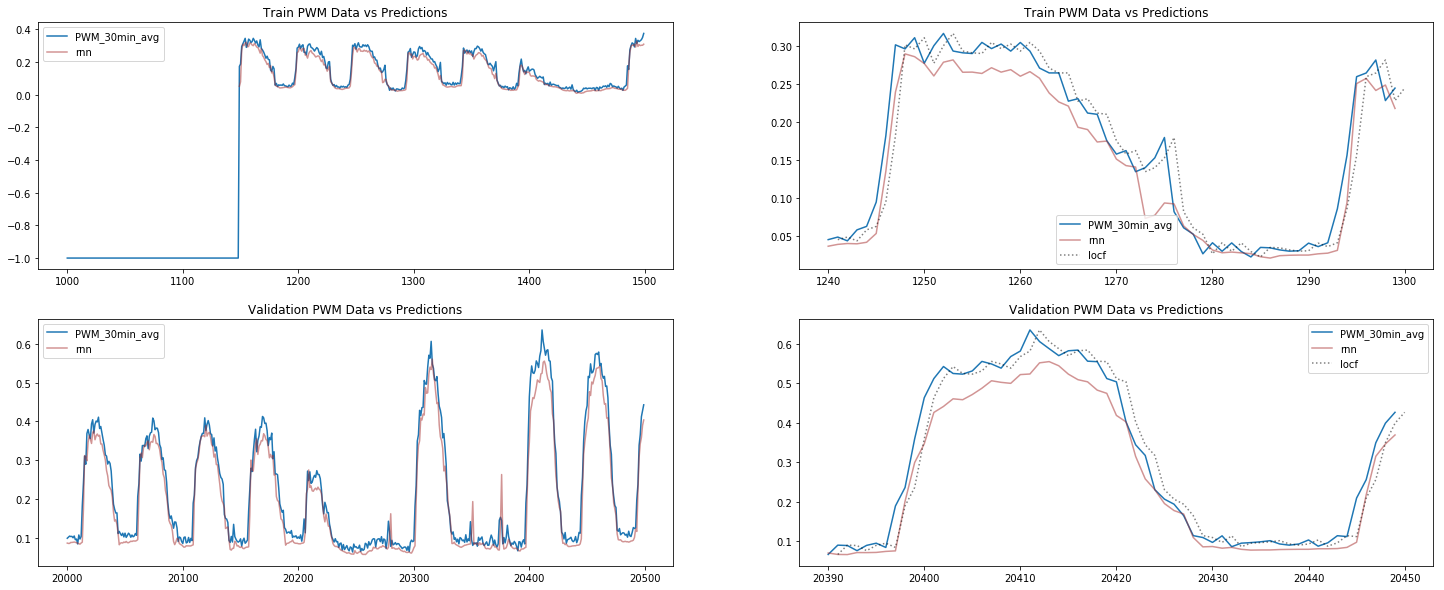

In [64]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [65]:
model.save('base-4x128gru-2x32dense-dropout0104.h5')

In [66]:
with open('base-4x128gru-2x32dense-dropout0104-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.2) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-1x0202-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout-1x0202.h5'))
model.summary()

In [22]:
callbacks = [
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [54]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2,
                              callbacks=callbacks)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))


Training start time = 2019-01-29 13:48:37.069840
Epoch 1/50
 - 83s - loss: 0.0132 - mean_absolute_percentage_error: 9.2550 - val_loss: 0.0582 - val_mean_absolute_percentage_error: 25.2833
Epoch 2/50
 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.1358 - val_loss: 0.0576 - val_mean_absolute_percentage_error: 24.6033
Epoch 3/50
 - 83s - loss: 0.0132 - mean_absolute_percentage_error: 9.1765 - val_loss: 0.0466 - val_mean_absolute_percentage_error: 18.5366
Epoch 4/50
 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.2159 - val_loss: 0.0519 - val_mean_absolute_percentage_error: 19.1926
Epoch 5/50
 - 82s - loss: 0.0131 - mean_absolute_percentage_error: 9.2520 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 19.2709
Epoch 6/50
 - 82s - loss: 0.0131 - mean_absolute_percentage_error: 9.1308 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 15.9808
Epoch 7/50
 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.1344 - val_loss: 0.0581 - val_mean_absolute_perc

In [55]:
# histories = [] # for first training session
histories.append(history.history)

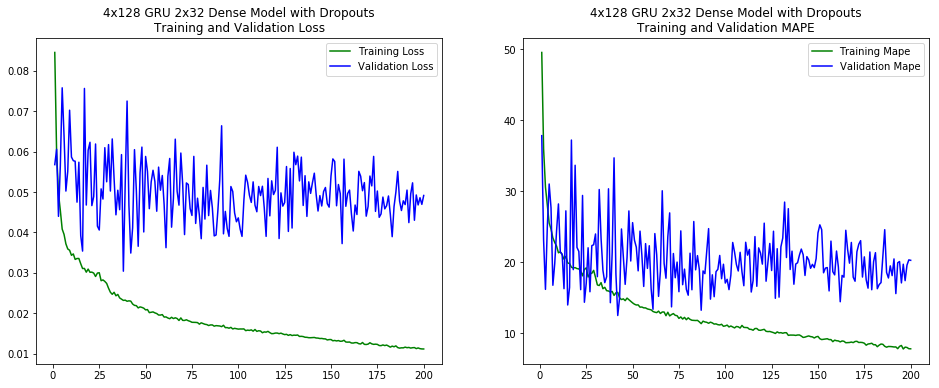

In [56]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [57]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.188571
Validation MAE = 3.235326


In [58]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [59]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

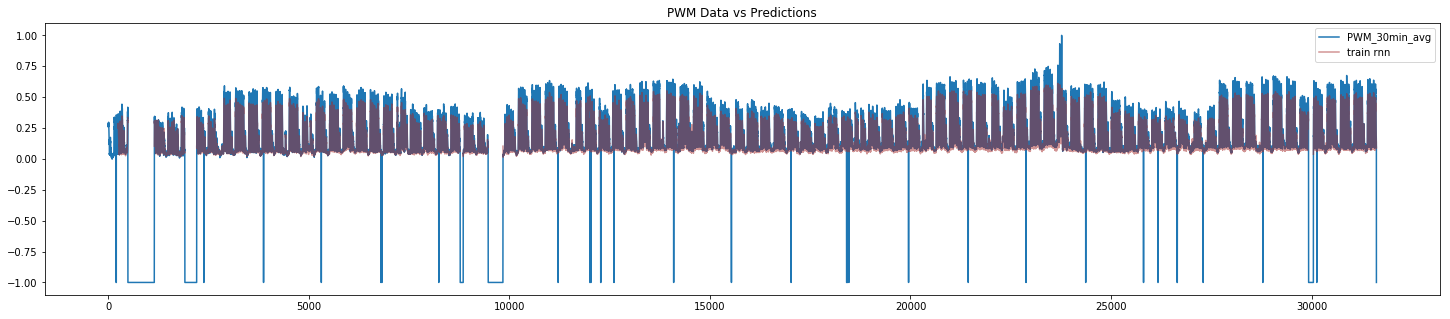

In [60]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

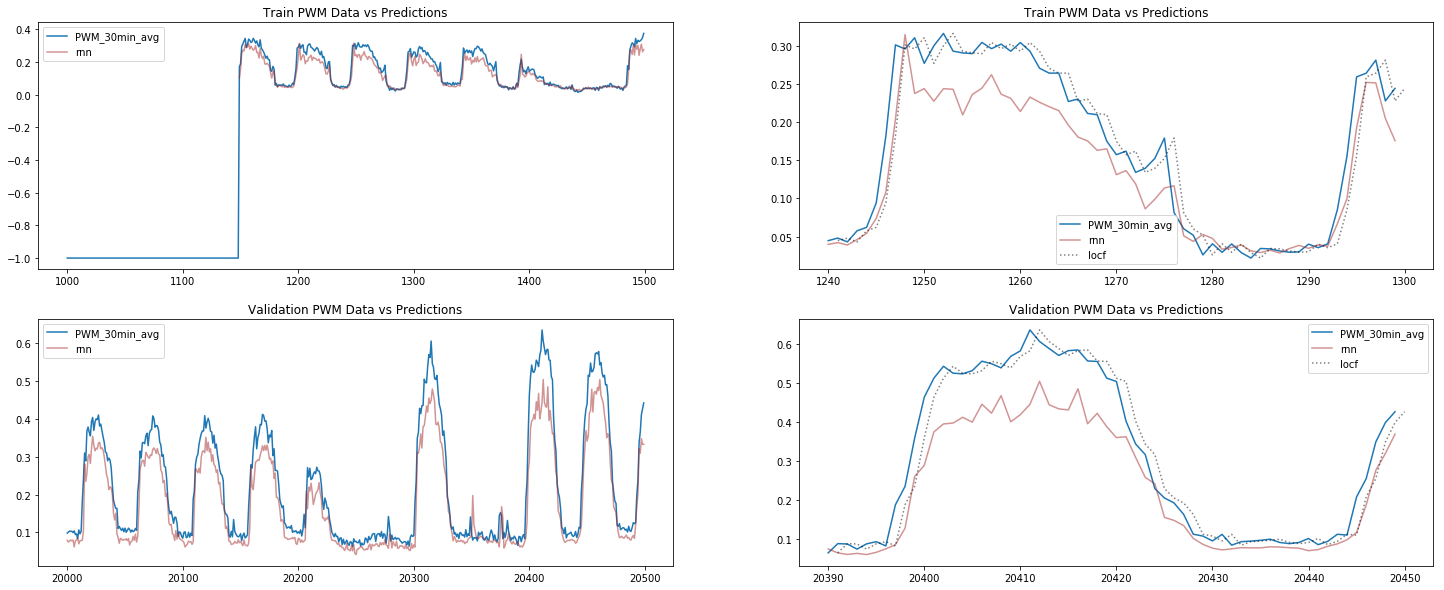

In [61]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [62]:
model.save('base-4x128gru-2x32dense-dropout1x0202.h5')

In [63]:
with open('base-4x128gru-2x32dense-dropout1x0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.05) and Recurrent Dropout (0.05)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.05, recurrent_dropout=0.05, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x005005-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x005005.h5'))
model.summary()

In [46]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 81s - loss: 0.0143 - mean_absolute_percentage_error: 9.8528 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3009
Epoch 2/50
 - 80s - loss: 0.0144 - mean_absolute_percentage_error: 10.2110 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 10.1580
Epoch 3/50
 - 79s - loss: 0.0142 - mean_absolute_percentage_error: 9.8094 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 10.2294
Epoch 4/50
 - 82s - loss: 0.0141 - mean_absolute_percentage_error: 9.7670 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.2976
Epoch 5/50
 - 81s - loss: 0.0139 - mean_absolute_percentage_error: 9.6537 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 10.4887
Epoch 6/50
 - 82s - loss: 0.0140 - mean_absolute_percentage_error: 9.8895 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 12.1973
Epoch 7/50
 - 81s - loss: 0.0138 - mean_absolute_percentage_error: 9.4852 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9067
Epoch 8/50
 - 81s - loss: 0.0

In [47]:
# histories = [] # for first training session
histories.append(history.history)

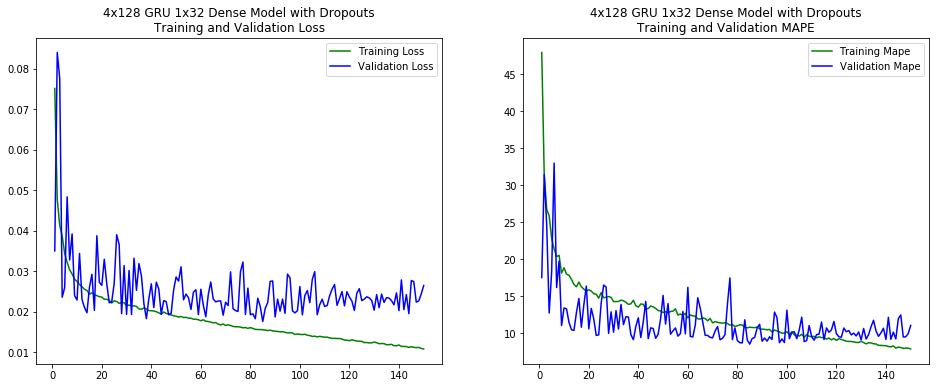

In [48]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [49]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.010789
Validation min loss = 0.017562
Validation min epoch = 84


In [50]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.147767
Validation MAE = 1.868231


In [51]:
as5_train_df['PWM_30min_avg'].min()

gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape


(29754, 1)

In [52]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

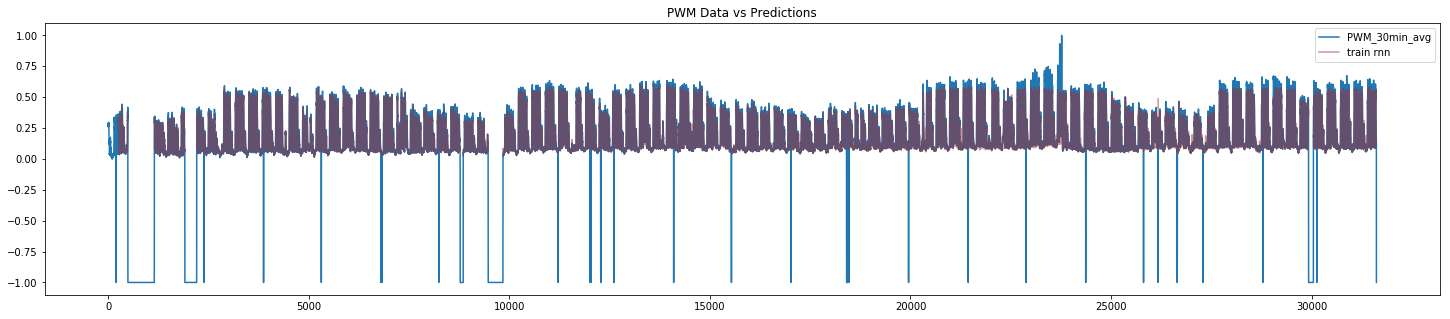

In [53]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

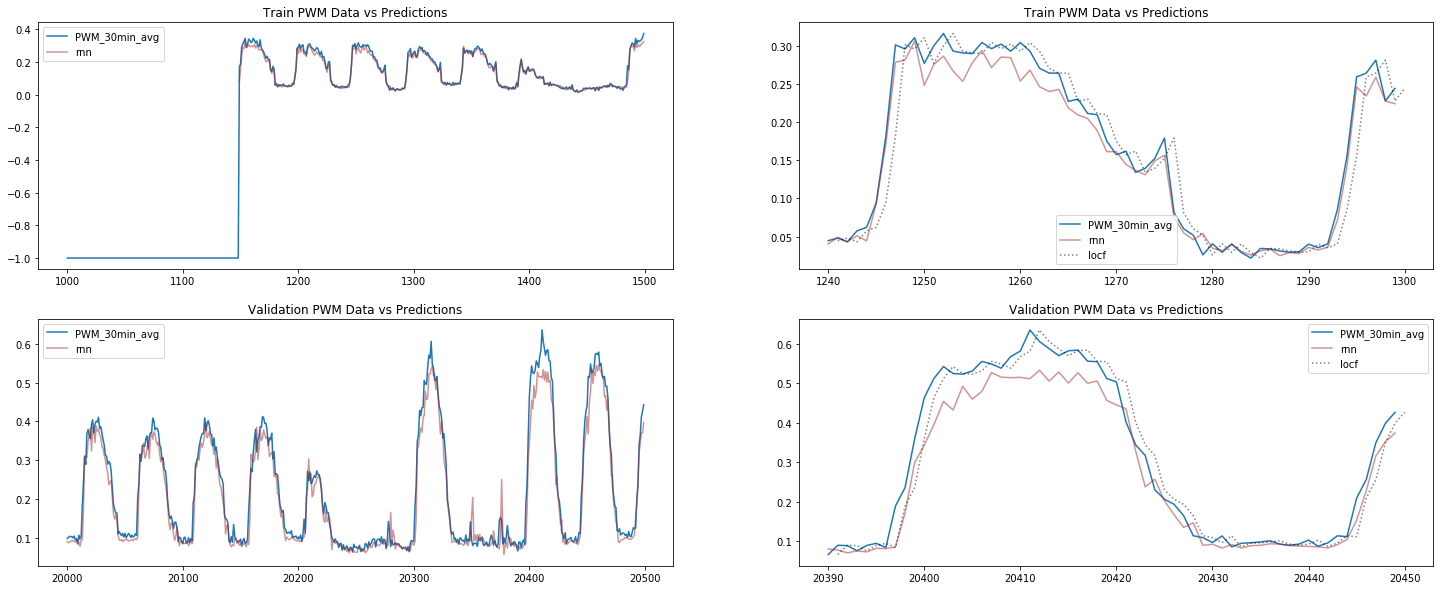

In [54]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [55]:
model.save('base-4x128gru-2x32dense-dropout1x005005.h5')

In [56]:
with open('base-4x128gru-2x32dense-dropout1x005005-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.1) and Recurrent Dropout (0.1)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [21]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101-histories-epch150.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101-epch150.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 82s - loss: 0.0124 - mean_absolute_percentage_error: 8.7079 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 14.1360
Epoch 2/50
 - 80s - loss: 0.0125 - mean_absolute_percentage_error: 8.5908 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 14.8605
Epoch 3/50
 - 81s - loss: 0.0122 - mean_absolute_percentage_error: 8.6965 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 10.7497
Epoch 4/50
 - 81s - loss: 0.0123 - mean_absolute_percentage_error: 8.5570 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 11.2606
Epoch 5/50
 - 79s - loss: 0.0121 - mean_absolute_percentage_error: 8.6427 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 11.5558
Epoch 6/50
 - 79s - loss: 0.0119 - mean_absolute_percentage_error: 8.4144 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 10.6531
Epoch 7/50
 - 79s - loss: 0.0120 - mean_absolute_percentage_error: 8.4668 - val_loss: 0.0414 - val_mean_absolute_percentage_error: 15.5226
Epoch 8/50
 - 79s - loss: 0

In [23]:
# histories = [] # for first training session
histories.append(history.history)

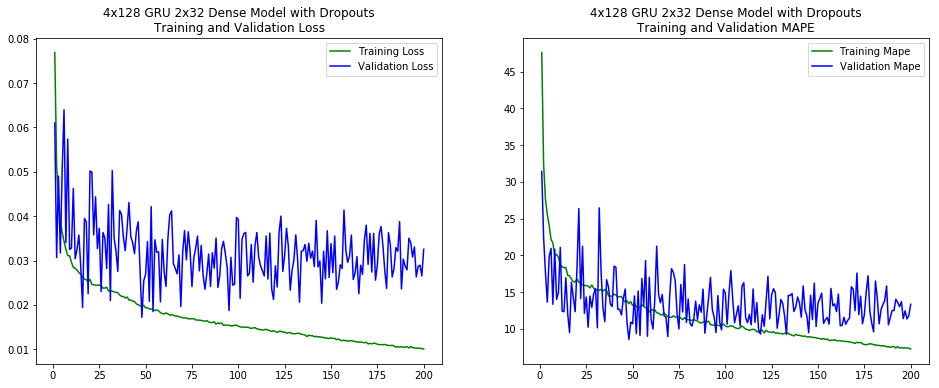

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.010057
Validation min loss = 0.017197
Validation min epoch = 47


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.069913
Validation MAE = 1.829380


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

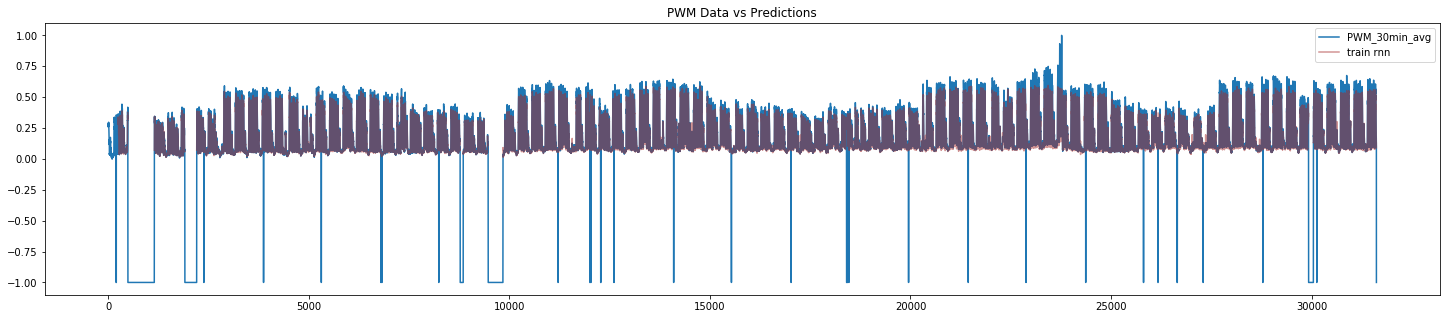

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

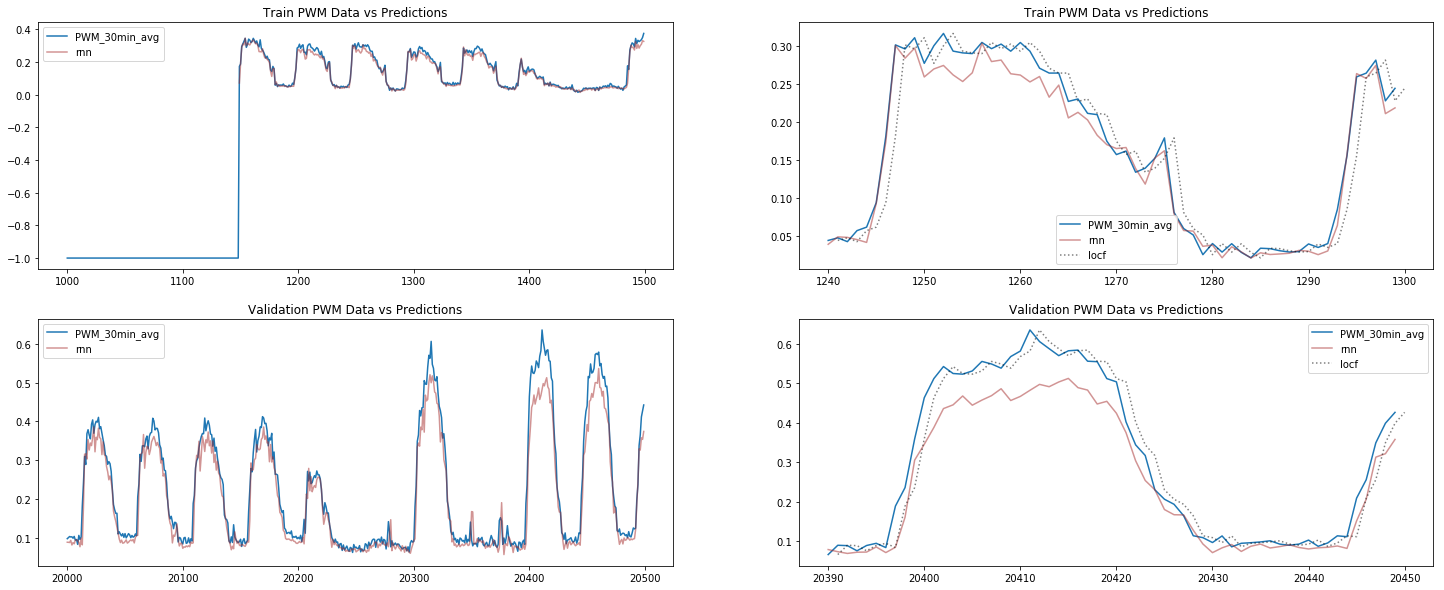

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-dropout1x0101.h5')

In [32]:
with open('base-4x128gru-2x32dense-dropout1x0101-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)